In [1005]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 


HYPERPARAMETERS

In [1006]:
# Hyperparameters
batch_size = 32 # batch size
seq_len = 128 # sequence length, block size

d_k = 256  # dimension of key, value, query
d_v = 256  # dimension of key, value, query
n_heads = 16 # number of heads in multi-head attention
ff_dim = 256 # hidden layer dimension in feedforward network
     

READ CSV FILE

In [1007]:
# Read CSV file
#only pick the 9th column
df = pd.read_csv('test2.csv', usecols=['Open', 'High', 'Low', 'Close', 'Volume'])
# drop NaN values
df = df.dropna()
df


,Open,High,Low,Close,Volume
0,4659,4666,4641,4647,960900
1,4653,4666,4647,4666,164300
2,4672,4678,4653,4675,710900
3,4681,4684,4669,4675,201000
4,4684,4706,4672,4703,775500
...,...,...,...,...,...
7321,40280,40513,40028,40059,74202018
7322,40113,40653,40077,40648,86811786
7323,40521,41367,40235,41080,101459155
7324,41486,41831,41288,41678,101654463


PLOT PRICE AND VOLUME

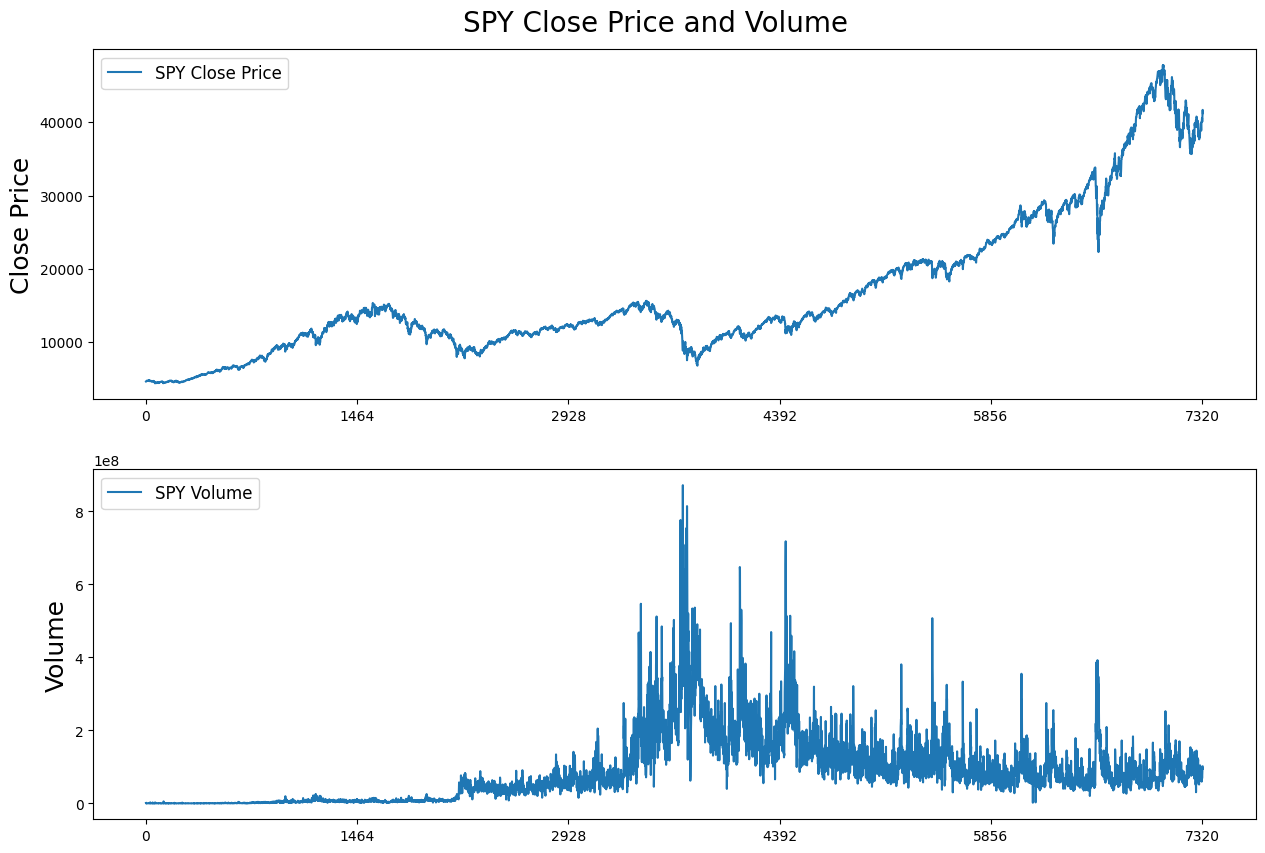

In [1008]:

fig = plt.figure(figsize=(15,10))
st = fig.suptitle("SPY Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label='SPY Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Volume'], label='SPY Volume')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)



NORMALIZE DELTA PERCENTAGE OF ALL COLUMNS

In [1009]:
'''Calculate percentage change'''

df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Create indexes to split dataset'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

###############################################################################
'''Normalize price columns'''
#
min_return = min(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df[(df.index < last_20pct)]['Volume'].min(axis=0)
max_volume = df[(df.index < last_20pct)]['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Create training, validation and test split'''

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)] # Validation data are 10% of total data
df_test = df[(df.index >= last_10pct)] # Test data are 10% of total data


# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()


Training data shape: (5860, 5)
Validation data shape: (733, 5)
Test data shape: (732, 5)


,Open,High,Low,Close,Volume
1,0.466623,0.471312,0.476019,0.486199,0.003661
2,0.486180,0.480676,0.476013,0.478335,0.100150
3,0.478326,0.475982,0.483833,0.471312,0.006256
4,0.473646,0.488414,0.473652,0.493120,0.089269
5,0.490746,0.512319,0.490796,0.514668,0.017466


PLOT DAILY CHANGES, CLOSE AND VOLUME

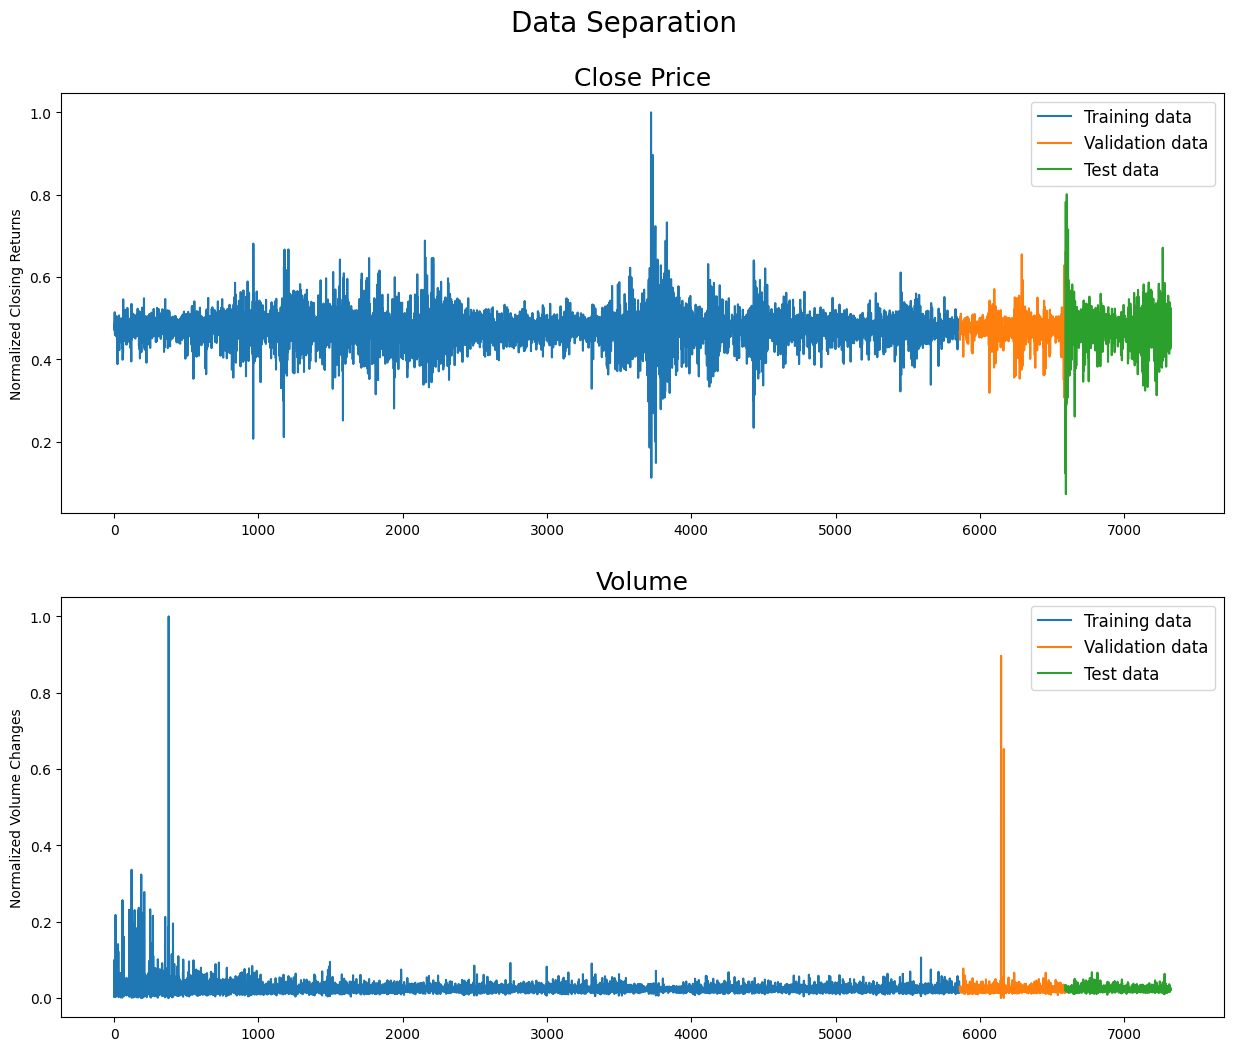

In [1010]:

fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

     

CREATE RANDOM BLOCKS TO TRAIN AND TEST/VAL

In [1011]:

# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
    # Extract the block of data
    block = train_data[i-seq_len:i]
    # Normalize the block
    min_block = np.min(block, axis=0)
    max_block = np.max(block, axis=0)
    block_normalized = (block - min_block) / (max_block - min_block)
    # Add the normalized block to the sequence list
    X_train.append(block_normalized)
    # Add the corresponding target value to the label list
    y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    # Extract the block of data
    block = val_data[i-seq_len:i]
    # Normalize the block
    min_block = np.min(block, axis=0)
    max_block = np.max(block, axis=0)
    block_normalized = (block - min_block) / (max_block - min_block)
    # Add the normalized block to the sequence list
    X_val.append(block_normalized)
    # Add the corresponding target value to the label list
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    # Extract the block of data
    block = test_data[i-seq_len:i]
    # Normalize the block
    min_block = np.min(block, axis=0)
    max_block = np.max(block, axis=0)
    block_normalized = (block - min_block) / (max_block - min_block)
    # Add the normalized block to the sequence list
    X_test.append(block_normalized)
    # Add the corresponding target value to the label list
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)


print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)




Training set shape (5732, 128, 5) (5732,)
Validation set shape (605, 128, 5) (605,)
Testing set shape (604, 128, 5) (604,)


TIMEVECTOR

In [1012]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [ ]:
import torch.nn as nn

class StockPredictorTransformer(nn.Module):
    def __init__(self, input_size, n_heads, d_k, d_v, ff_dim, num_layers):
        super(StockPredictorTransformer, self).__init__()
        
        # Define your model layers and components here
        self.embedding = nn.Linear(input_size, d_k)
        # use a sine/cosine-based position encoding or learnable embeddings
        self.position_encoding = nn.Parameter(torch.randn(1, seq_len, d_k) * 0.1)
        self.transformer_layer = nn.TransformerEncoderLayer(d_k, n_heads, ff_dim)
        self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_k, 1)  # Output layer
        

    def forward(self, x):
        x = self.embedding(x)
        x = x + self.position_encoding
        x = self.transformer(x)
        x = self.fc(x)
        return x.mean(dim=1)




In [ ]:
#Instantiate the StockPredictorTransformer model with your desired hyperparameters:

input_size = 5  # Number of input features (e.g., Open, High, Low, Close, Volume)
num_layers = 8  # Number of encoder layers

model = StockPredictorTransformer(input_size, n_heads, d_k, d_v, ff_dim, num_layers)


In [ ]:
import torch.optim as optim
# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean squared error loss
optimizer = optim.Adam(model.parameters(), lr=0.0000004)  # Adam optimizer with learning rate 0.001


In [ ]:
# Create a function to train the model
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    running_loss /= len(dataloader)
    return running_loss


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

StockPredictorTransformer(
  (embedding): Linear(in_features=5, out_features=256, bias=True)
  (transformer_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (linear1): Linear(in_features=256, out_features=256, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=256, out_features=256, bias=True)
    (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=256

In [ ]:
print(device)

cpu


In [ ]:
from torch.utils.data import DataLoader, TensorDataset



# Convert the numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
device = torch.device("mps")

# Move the model to the device
model.to(device)

StockPredictorTransformer(
  (embedding): Linear(in_features=5, out_features=256, bias=True)
  (transformer_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (linear1): Linear(in_features=256, out_features=256, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=256, out_features=256, bias=True)
    (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=256

In [ ]:

print(device)

mps


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
%config IPCompleter.greedy=True


# Training parameters
num_epochs = 50
results_df = pd.DataFrame(columns=['Epoch', 'Train Loss', 'Validation Loss'])



# Keep track of the best validation loss to save the best model
best_val_loss = float("inf")



# Skapa din modell (det måste vara samma struktur som den du sparade)
model = StockPredictorTransformer(input_size, n_heads, d_k, d_v, ff_dim, num_layers)
import torch.optim as optim
# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean squared error loss
optimizer = optim.Adam(model.parameters(), lr=0.00001)  # Adam optimizer with learning rate 0.001
# Ladda modellen
model.load_state_dict(torch.load('best_model.pth'))

# Flytta modellen till enheten
model.to(device)



for epoch in range(num_epochs):
    # Train the model for one epoch
    train_loss = train_model(model, train_dataloader, criterion, optimizer, device)
    
    # Evaluate the model on the validation set
    model.eval()
    val_loss = 0.0
    y_true_list = []
    y_pred_list = []

    with torch.no_grad():
        for inputs, targets in val_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()
            y_true_list.append(targets.cpu().numpy())
            y_pred_list.append(outputs.squeeze().cpu().numpy())

    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)

    val_loss /= len(val_dataloader)
    
    # Print the losses and metrics for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.10f}, Validation Loss: {val_loss:.10f}")
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    print(f'Mean Squared Error: {mse:.10f}, Mean Absolute Error: {mae:.10f}')
    print('---')

    new_row = pd.DataFrame({'Epoch':[epoch+1], 'Train Loss':[train_loss], 'Validation Loss':[val_loss]})
    results_df = pd.concat([results_df, new_row], ignore_index=True)

    # Save the model if the validation loss improved
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), "best_model2.pth")
        best_val_loss = val_loss

# Save results to csv
results_df.to_csv('to_csv2.csv', index=False)


Epoch 1/800
Train Loss: 0.0023682661, Validation Loss: 0.0015446463
Mean Squared Error: 0.0015062208, Mean Absolute Error: 0.0250021666
---
Epoch 2/800
Train Loss: 0.0023251897, Validation Loss: 0.0015592688
Mean Squared Error: 0.0015207281, Mean Absolute Error: 0.0251440685
---
Epoch 3/800
Train Loss: 0.0021905637, Validation Loss: 0.0014942886
Mean Squared Error: 0.0014573511, Mean Absolute Error: 0.0245866161
---
Epoch 4/800
Train Loss: 0.0022283230, Validation Loss: 0.0018274187
Mean Squared Error: 0.0017884345, Mean Absolute Error: 0.0291523896
---


KeyboardInterrupt: 

<AxesSubplot: title={'center': 'Training Results'}, xlabel='Epoch'>

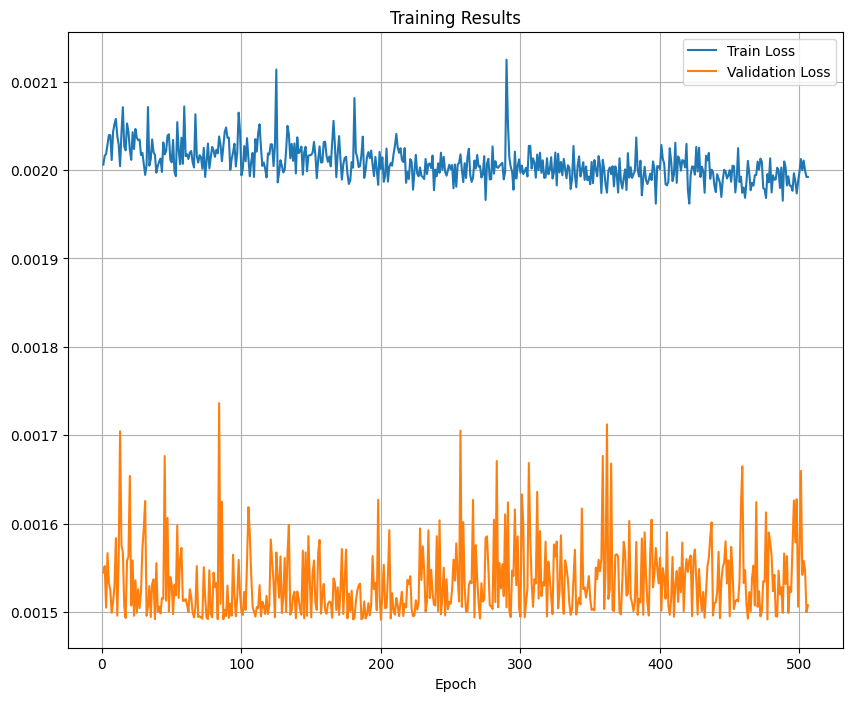

In [ ]:
# plot the results_df dataframe to a graph
results_df[0:].plot(y=['Train Loss', 'Validation Loss'], x='Epoch', figsize=(10, 8), title='Training Results', grid=True)